In [1]:
%matplotlib inline
import os
import glob
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import sqlite3
import lsst.afw.geom as afw_geom
import lsst.afw.cameraGeom as cameraGeom
import lsst.daf.persistence as dp
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import lsst.obs.lsstSim as obs_lsstSim
    import lsst.sims.coordUtils
    from lsst.sims.catUtils.utils import ObservationMetaDataGenerator
    from lsst.sims.utils import getRotSkyPos

In [2]:
def makePatch(vertexList, wcs=None):
    """Return a path in sky coords from vertex list in pixel coords"""
    if wcs is not None:
        skyPatchList = [wcs.pixelToSky(pos).getPosition(afw_geom.degrees)
                        for pos in vertexList]
    else:
        skyPatchList = vertexList
    verts = [(coord[0], coord[1]) for coord in skyPatchList]
    verts.append((0,0))
    codes = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY,
             ]
    return Path(verts, codes)

In [3]:
def plotSkyMap(skyMap, tract=0, title=None, ax=None):
    if title is None:
        title = 'tract {}'.format(tract)
    tractInfo = skyMap[tract]
    tractBox = afw_geom.Box2D(tractInfo.getBBox())
    tractPosList = tractBox.getCorners()
    wcs = tractInfo.getWcs()
    xNum, yNum = tractInfo.getNumPatches()

    if ax is None:
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)

    tract_center = wcs.pixelToSky(tractBox.getCenter())\
                      .getPosition(afw_geom.degrees)
    ax.text(tract_center[0], tract_center[1], '%d' % tract, size=16,
            ha="center", va="center", color='blue')
    for x in range(xNum):
        for y in range(yNum):
            patchInfo = tractInfo.getPatchInfo([x, y])
            patchBox = afw_geom.Box2D(patchInfo.getOuterBBox())
            pixelPatchList = patchBox.getCorners()
            path = makePatch(pixelPatchList, wcs)
            patch = patches.PathPatch(path, alpha=0.1, lw=1)
            ax.add_patch(patch)
            center = wcs.pixelToSky(patchBox.getCenter())\
                        .getPosition(afw_geom.degrees)
            ax.text(center[0], center[1], '%d,%d'%(x,y), size=6,
                    ha="center", va="center")

    skyPosList = [wcs.pixelToSky(pos).getPosition(afw_geom.degrees)
                  for pos in tractPosList]
    ax.set_xlim(max(coord[0] for coord in skyPosList) + 1,
                min(coord[0] for coord in skyPosList) - 1)
    ax.set_ylim(min(coord[1] for coord in skyPosList) - 1,
                max(coord[1] for coord in skyPosList) + 1)
    ax.grid(ls=':',color='gray')
    ax.set_xlabel("RA (deg.)")
    ax.set_ylabel("Dec (deg.)")
    ax.set_title(title)
    return ax

In [4]:
def plot_focal_plane(butler, visit, ax, color='red'):
    datarefs = list(butler.subset('calexp', visit=visit))
    for i, dataref in enumerate(datarefs):
        calexp = dataref.get('calexp')
        ccd_box = afw_geom.Box2D(calexp.getBBox())
        wcs = calexp.getWcs()
        path = makePatch(ccd_box.getCorners(), wcs)
        ccd = patches.PathPatch(path, alpha=0.2, lw=1, color='red')
        ax.add_patch(ccd)
        center = wcs.pixelToSky(ccd_box.getCenter()).getPosition(afw_geom.degrees)
        #ax.text(center[0], center[1], '%s' % calexp.getDetector().getName(), ha='center', va='center', color=color)
    return ax

In [5]:
def plot_focal_plane_fast(butler, visit, ax, color='red', opsimdb=None):
    if opsimdb is None:
        opsimdb = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
    conn = sqlite3.connect(opsimdb)
    obs_gen = ObservationMetaDataGenerator(database=opsimdb, driver='sqlite')
    curs = conn.execute('''select descDitheredRA, descDitheredDec, descDitheredRotTelPos
                        from summary where obshistid={}'''.format(visit))
    ra, dec, rottelpos = [np.degrees(x) for x in curs][0]
    obs_md = obs_gen.getObservationMetaData(obsHistID=visit, boundType='circle', boundLength=0.1)[0]
    obs_md.pointingRA = ra
    obs_md.pointingDec = dec
    obs_md.OpsimMetaData['rotTelPos'] = rottelpos
    obs_md.rotSkyPos = getRotSkyPos(ra, dec, obs_md, rottelpos)
    camera = obs_lsstSim.LsstSimMapper().camera
    dataref = list(butler.subset('calexp', visit=visit))[0]
    calexp_path = os.path.dirname(os.path.dirname(dataref.get('calexp_filename')[0]))
    corner_index = (np.array([0, 1, 3, 2]),)
    for det in camera:
        if det.getType() != cameraGeom.SCIENCE:
            continue
        detname = det.getName()
        raft = 'R{}{}'.format(*detname[2:5:2])
        sensor = 'S{}{}.fits'.format(*detname[8:11:2])
        if os.path.isfile(os.path.join(calexp_path, raft, sensor)):
            corners = np.array(lsst.sims.coordUtils.getCornerRaDec(detname, camera, obs_md))
            path = makePatch(corners[corner_index])
            ccd = patches.PathPatch(path, alpha=0.2, lw=1, color='red')
            ax.add_patch(ccd)
    return ax

In [6]:
def plot_protoDC2_region(ax):
    uddf_ra = [53.764, 52.486, 52.479, 53.771, 53.764]
    uddf_dec = [-27.533, -27.533, -28.667, -28.667, -27.533]

    wfd_ra = [52.25, 52.11, 58.02, 57.87, 52.25]
    wfd_dec = [-27.25, -32.25, -32.25, -27.25, -27.25]

    ax.errorbar(wfd_ra, wfd_dec, fmt='-', color='green',
                label='protoDC2 boundary')
    ax.errorbar(uddf_ra, uddf_dec, fmt='-', color='red',
                label='DDF boundary')

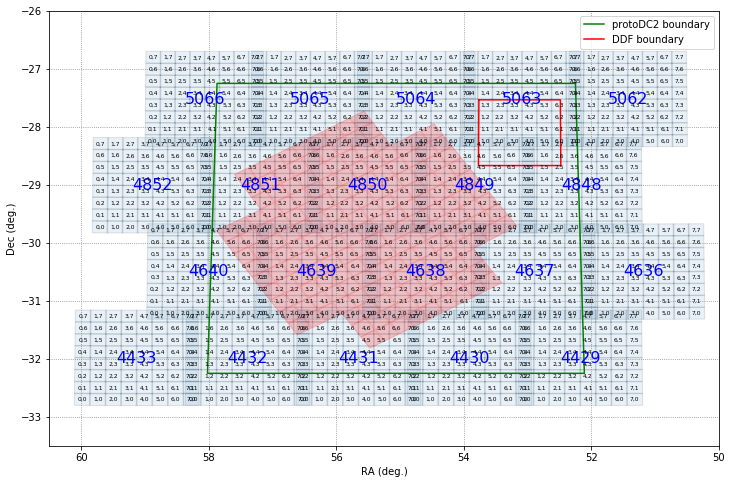

In [7]:
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
visit = 219976
butler = dp.Butler(repo)
tracts = sorted([int(os.path.basename(x)) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', '*'))])
ax = None
for tract in tracts:
    skyMap = butler.get('deepCoadd_skyMap')
    ax = plotSkyMap(skyMap, tract=tract, title='', ax=ax)
plot_focal_plane_fast(butler, visit, ax)
plot_protoDC2_region(ax)
ax.set_xlim(60.5, 50)
ax.set_ylim(-33.5, -26)
plt.legend(loc=0);